In [1]:
%%time
%run theory_basics.ipynb

CPU times: user 5min 51s, sys: 15min 6s, total: 20min 57s
Wall time: 2min 19s


In [2]:
%run dream_basics.ipynb

In [3]:
matplotlib.rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
matplotlib.rc('text', usetex=True)

# Basics

In [4]:
simulation_duration_dream = 10 * T
t_dream = np.arange(0, simulation_duration_dream, dt)

In [5]:
X_dream, w_dream, W_dream, DW_dream, DX_dream = simulate(
    dt,
    N,
    T,
    t_dream,
    theta,
    alpha,
    beta,
    delay_i,
    lmbda,
    w.copy(),
    get_dw_prime_mean,
    get_dx,
    f_I_conv_circ_fft,
    phi,
    u,
    stimulate=False,
    full_info=True,
    init_steps=2*N
)

/tmp/ipykernel_11569/2120848042.py:26: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


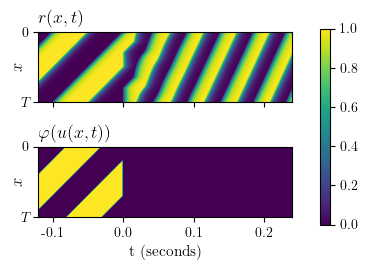

In [28]:
%matplotlib inline
fig, axes = plt.subplots(2, 1, figsize=(5.2, 2.8), sharex=True)
start = 400
end = 2200
data = X_dream[start:end].T
t_data = t_dream[start:end]
U = phi(u(t_data[start:2*N, np.newaxis] + theta, T))
im_data = axes[0].imshow(data, vmax=1, vmin=0,
                         extent=[t_data[0], t_data[-1], N/len(data.T)*(t_data[-1]-t_data[0]), 0])
axes[0].set_yticks([0, T], [r'$0$', r'$T$'])
axes[0].set_ylabel('$x$', fontsize=12, labelpad=-3)
axes[1].imshow(np.vstack((U, np.zeros((end-2*N, N)))).T, vmax=1, vmin=0,
               extent=[t_data[0], t_data[-1], N/len(data.T)*(t_data[-1]-t_data[0]), 0])
axes[1].set_xticks(np.arange(0.1, 0.5, 0.1), np.arange(-0.1, 0.21, 0.1).round(1))
axes[1].set_xlabel(r"t (seconds)", fontsize=11)
axes[1].set_yticks([0, T], [r'$0$', r'$T$'])
axes[1].set_ylabel('$x$', fontsize=12, labelpad=-3)
axes[0].set_title(r"$r(x, t)$", size=13, loc='left')
axes[1].set_title(r"$\varphi(u(x, t))$", size=13, loc='left')
#sm0 = plt.cm.ScalarMappable(cmap=plt.cm.viridis, norm=plt.Normalize(vmin=0, vmax=1))
#plt.colorbar(sm0, ax=axes[0], aspect=12, location='left', ticks=[0, 1]).set_label(label=r"$r(x, t)$", size=12)
#sm1 = plt.cm.ScalarMappable(cmap=plt.cm.viridis, norm=plt.Normalize(vmin=0, vmax=1))
#plt.colorbar(sm1, ax=axes[1], aspect=12, location='left', ticks=[0, 1]).set_label(label=r"$\varphi(u(x, t))$", size=12)
cax = fig.add_axes([0.8, 0.18, 0.02, 0.7])
plt.colorbar(im_data, cax=cax)
plt.tight_layout()
plt.savefig('../latex/images/basic_replay.pdf', bbox_inches='tight')

# Stable Frequencies

In [13]:
omegas = np.linspace(-3, 3, 250)
lhs = np.array([np.angle(1 + 2 * np.pi * 1j * tau_x * omega / T) for omega in omegas])
slope = 2 * np.pi * tau_x / T

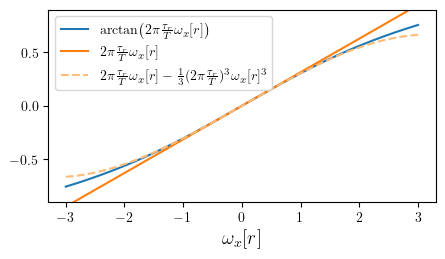

In [14]:
tab20 = matplotlib.colormaps.get_cmap('tab20')
plt.figure(figsize=(5, 2.5))
plt.plot(omegas, lhs, color=tab20(0), label=r'arctan$\left(2 \pi \frac{\tau_r}{T}\omega_x[r]\right)$')
#lhs_f = np.polynomial.polynomial.Polynomial([0, a, 0, -(a**3)/3])
#plt.plot(omegas, lhs_f(omegas), linestyle='dashed')
plt.plot(omegas, [slope * omega for omega in omegas],
         color=tab20(2), label=r'$2 \pi \frac{\tau_r}{T}\omega_x[r]$')
plt.plot(omegas, [slope * omega - (slope**3)/3 * omega**3 for omega in omegas],
         color=tab20(3), linestyle='dashed', label=r'$2 \pi \frac{\tau_r}{T}\omega_x[r] - \frac{1}{3}(2 \pi \frac{\tau_r}{T})^3 \omega_x[r]^3$')
plt.xlabel(r'$\omega_x[r]$', fontsize=14)
plt.ylim(-0.9, 0.9)
plt.legend()
#plt.title('accuracy of taylor series approximation of arctan')
#plt.savefig('../latex/images/arctan_taylor_approximation.pdf', bbox_inches='tight')

### numeric

In [23]:
omegas = np.linspace(-12, 12, 600)
lhs = np.array([np.angle(1 + 2 * np.pi * 1j * tau_x * omega / T) for omega in omegas])
rhs = np.array([to_theta(np.angle(1j) - np.angle(np.exp(-2*np.pi*1j*tau_d/T)) + to_theta(-omega * 2 * np.pi * delay_i / N)) for omega in omegas])
thresh = 0.025
omega_roots_numeric_old = omegas[np.abs(rhs-lhs) < thresh]

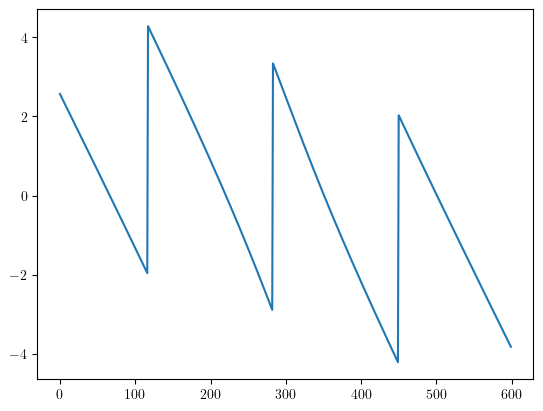

In [24]:
plt.plot((rhs-lhs))

In [4]:
def find_zero_crossings(time_series):
    crossings = []
    for i in range(1, len(time_series)):
        if time_series[i-1] > 0 and time_series[i] < 0:  # Sign change
            x1, y1 = i-1, time_series[i-1]
            x2, y2 = i, time_series[i]
            crossing = x1 - y1 * (x2 - x1) / (y2 - y1)
            crossings.append(crossing)
    return np.array(crossings)

In [5]:
def omega_space(x):
    return omegas[0] + (omegas[-1] - omegas[0]) / len(omegas) * x

In [125]:
omega_roots_numeric = omega_space(find_zero_crossings(rhs-lhs))

In [126]:
omega_roots_numeric, omega_roots_numeric_old

(array([-9.35264029, -3.1837456 ,  2.0343317 ,  8.03205822]),
 array([-9.35559265, -3.18530885,  2.06343907,  8.07345576]))

In [128]:
%%time
simulation_duration_dream = 10 * T
t_dream = np.arange(0, simulation_duration_dream, dt)
X_comp = []

for omega_root in omega_roots_numeric:
    # beta = 0
    X_, _ = simulate(dt, N, T, t_dream, theta, alpha, 0, delay_i, lmbda, w.copy(), get_dw_prime_mean, get_dx, f_I_conv_circ_fft, phi, u, full_info=False,
                     stimulate=False, init_stimulation=True, init_travel=omega_root, init_steps=2*N)
    X_comp.append(X_)

CPU times: user 6.93 s, sys: 5.29 ms, total: 6.94 s
Wall time: 6.94 s


/tmp/ipykernel_11569/3768331979.py:31: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


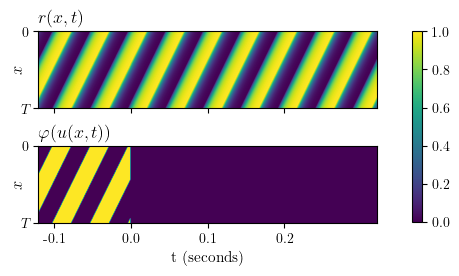

In [129]:
%matplotlib inline
fig, axes = plt.subplots(2, 1, figsize=(5.2, 2.8), sharex=True)
start = 400
end = 2600
j = 2
if omega_roots_numeric[j] > 0:
    t_init = np.arange(0, 2*N, omega_roots_numeric[j]*dt)
else:
    t_init = np.arange(2*N, 0, omega_roots_numeric[j]*dt)
data = X_comp[j][start:end].T
t_data = t_dream[start:end]
U = phi(u(t_init[start:2*N, np.newaxis] + theta, T))
axes[0].imshow(data, vmax=data.max(), vmin=data.min(),
               extent=[t_data[0], t_data[-1], N/len(data.T)*(t_data[-1]-t_data[0]), 0])
axes[0].set_yticks([0, T], [r'$0$', r'$T$'])
axes[0].set_ylabel('$x$', fontsize=12, labelpad=-3)
axes[1].imshow(np.vstack((U, np.zeros((end-2*N, N)))).T,
               extent=[t_data[0], t_data[-1], N/len(data.T)*(t_data[-1]-t_data[0]), 0])
axes[1].set_xticks(np.arange(0.1, 0.5, 0.1), np.arange(-0.1, 0.21, 0.1).round(1))
axes[1].set_xlabel(r"t (seconds)", fontsize=11)
axes[1].set_yticks([0, T], [r'$0$', r'$T$'])
axes[1].set_ylabel('$x$', fontsize=12, labelpad=-3)
axes[0].set_title(r"$r(x, t)$", size=13, loc='left')
axes[1].set_title(r"$\varphi(u(x, t))$", size=13, loc='left')
#sm0 = plt.cm.ScalarMappable(cmap=plt.cm.viridis, norm=plt.Normalize(vmin=0, vmax=1))
#plt.colorbar(sm0, ax=axes[0], aspect=12, location='left', ticks=[0, 1]).set_label(label=r"$r(x, t)$", size=12)
#sm1 = plt.cm.ScalarMappable(cmap=plt.cm.viridis, norm=plt.Normalize(vmin=0, vmax=1))
#plt.colorbar(sm1, ax=axes[1], aspect=12, location='left', ticks=[0, 1]).set_label(label=r"$\varphi(u(x, t))$", size=12)
cax = fig.add_axes([0.92, 0.2, 0.02, 0.68])
plt.colorbar(im_data, cax=cax)
plt.tight_layout()

/tmp/ipykernel_11569/9081236.py:57: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


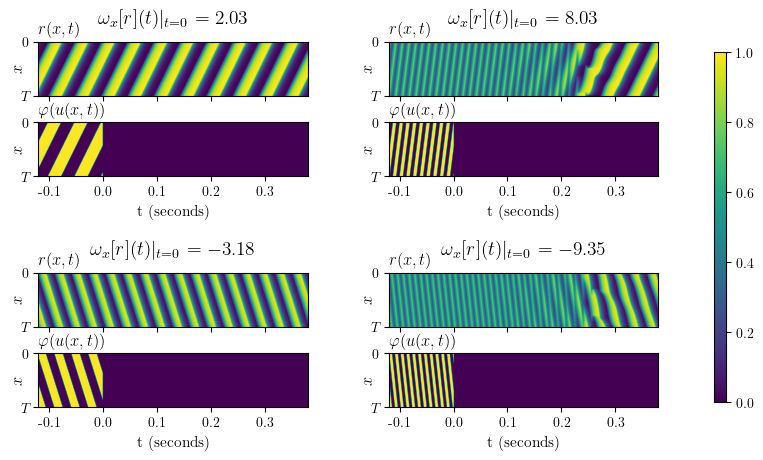

In [132]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

fig = plt.figure(figsize=(8, 5))
# Define the outer GridSpec
outer_gs = gridspec.GridSpec(2, 2, hspace=0.5, wspace=0.3)

start = 400
end = 2900

for i, j in enumerate([2, 3, 1, 0]):
    # Define the inner GridSpec for each (2x1) cell
    inner_gs = gridspec.GridSpecFromSubplotSpec(2, 1, subplot_spec=outer_gs[i], hspace=0.1)

    # Creating a ghost axis for the title
    ax_ghost = fig.add_subplot(outer_gs[i], frame_on=False)
    ax_ghost.set_xticks([])
    ax_ghost.set_yticks([])
    ax_ghost.set_title(r"$\omega_x[r](t)|_{t=0}$ " + f"$ = {omega_roots_numeric[j].round(2)}$", size=14)
    ax_ghost.grid(False)

    if omega_roots_numeric[j] > 0:
        t_init = np.arange(0, 2*N, omega_roots_numeric[j]*dt)
    else:
        t_init = np.arange(2*N, 0, omega_roots_numeric[j]*dt)
    data = X_comp[j][start:end].T
    t_data = t_dream[start:end]
    U = phi(u(t_init[start:2*N, np.newaxis] + theta, T))

    # Create axes for data and U plots
    ax_data = fig.add_subplot(inner_gs[0, 0])
    ax_U = fig.add_subplot(inner_gs[1, 0])

    # Plotting data
    im_data = ax_data.imshow(data, vmax=1, vmin=0,
                             extent=[t_data[0], t_data[-1], N/len(data.T)*(t_data[-1]-t_data[0]), 0])
    ax_data.set_xticks(np.arange(0.1, 0.51, 0.1), [])
    ax_data.set_yticks([0, T])
    ax_data.set_yticklabels([r'$0$', r'$T$'])
    ax_data.set_ylabel('$x$', fontsize=12, labelpad=-3)
    ax_data.set_title(r"$r(x, t)$", size=12, loc='left')

    # Plotting U
    im_U = ax_U.imshow(np.vstack((U, np.zeros((end-2*N, N)))).T, vmin=0, vmax=1,
                       extent=[t_data[0], t_data[-1], N/len(data.T)*(t_data[-1]-t_data[0]), 0])
    ax_U.set_xticks(np.arange(0.1, 0.51, 0.1), np.arange(-0.1, 0.31, 0.1).round(1))
    ax_U.set_xlabel(r"t (seconds)", fontsize=11)
    ax_U.set_yticks([0, T])
    ax_U.set_yticklabels([r'$0$', r'$T$'])
    ax_U.set_ylabel('$x$', fontsize=12, labelpad=-3)
    ax_U.set_title(r"$\varphi(u(x, t))$", size=12, loc='left')

# Create an axis for the colorbar on the right of the figure
cax = fig.add_axes([0.97, 0.14, 0.015, 0.7])
plt.colorbar(im_data, cax=cax)

plt.tight_layout()

plt.savefig('../latex/images/stable_replay_frequencies.pdf', bbox_inches='tight')

/tmp/ipykernel_23526/545495166.py:65: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


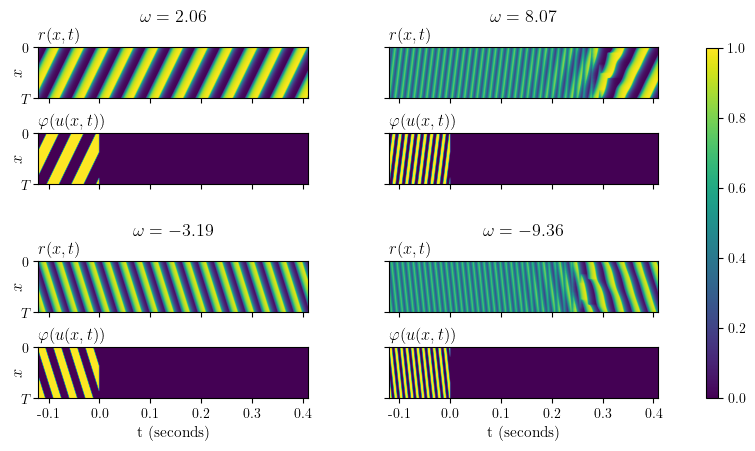

In [178]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

fig = plt.figure(figsize=(8, 5))
# Define the outer GridSpec
outer_gs = gridspec.GridSpec(2, 2, hspace=0.25, wspace=0.3)

start = 400
end = 3050

for i, j in enumerate([2, 3, 1, 0]):
    # Define the inner GridSpec for each (2x1) cell
    inner_gs = gridspec.GridSpecFromSubplotSpec(2, 1, subplot_spec=outer_gs[i], hspace=0.01)

    # Creating a ghost axis for the title
    ax_ghost = fig.add_subplot(outer_gs[i], frame_on=False)
    ax_ghost.set_xticks([])
    ax_ghost.set_yticks([])
    ax_ghost.set_title(f"$\omega = {omega_roots_numeric[j].round(2)}$", size=13)
    ax_ghost.grid(False)

    if omega_roots_numeric[j] > 0:
        t_init = np.arange(0, 2*N, omega_roots_numeric[j]*dt)
    else:
        t_init = np.arange(2*N, 0, omega_roots_numeric[j]*dt)
    data = X_comp[j][start:end].T
    t_data = t_dream[start:end]
    U = phi(u(t_init[start:2*N, np.newaxis] + theta, T))

    # Create axes for data and U plots
    ax_data = fig.add_subplot(inner_gs[0, 0])
    ax_U = fig.add_subplot(inner_gs[1, 0])

    # Plotting data
    im_data = ax_data.imshow(data, vmax=1, vmin=0,
                             extent=[t_data[0], t_data[-1], N/len(data.T)*(t_data[-1]-t_data[0]), 0])
    ax_data.set_xticks(np.arange(0.1, 0.61, 0.1), [])
    ax_data.set_yticks([0, T])
    ax_data.set_title(r"$r(x, t)$", size=12, loc='left')

    # Plotting U
    im_U = ax_U.imshow(np.vstack((U, np.zeros((end-2*N, N)))).T, vmin=0, vmax=1,
                       extent=[t_data[0], t_data[-1], N/len(data.T)*(t_data[-1]-t_data[0]), 0])
    if i > 1:
        ax_U.set_xticks(np.arange(0.1, 0.61, 0.1), np.arange(-0.1, 0.41, 0.1).round(1))
        ax_U.set_xlabel(r"t (seconds)", fontsize=11)
    else:
        ax_U.set_xticks(np.arange(0.1, 0.61, 0.1), [])
    ax_U.set_yticks([0, T])

    if i in (0, 2):
        ax_U.set_yticklabels([r'$0$', r'$T$'])
        ax_U.set_ylabel('$x$', fontsize=12, labelpad=-3)
        ax_data.set_yticklabels([r'$0$', r'$T$'])
        ax_data.set_ylabel('$x$', fontsize=12, labelpad=-3)
    else:
        ax_U.set_yticklabels([])
        ax_data.set_yticklabels([])
    ax_U.set_title(r"$\varphi(u(x, t))$", size=12, loc='left')

# Create an axis for the colorbar on the right of the figure
cax = fig.add_axes([0.96, 0.145, 0.015, 0.7])
plt.colorbar(im_data, cax=cax)

plt.tight_layout()

#plt.savefig('../latex/images/stable_replay_frequencies.pdf', bbox_inches='tight')

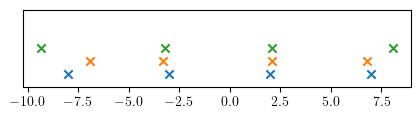

In [88]:
coeff_set = [
    [
        np.pi/2 + 2*np.pi*tau_d / T + k_ * 2 * np.pi,
        -(tau_d + tau_x) * 2 * np.pi / T
    ]
    for k_ in range(-2, 2)
]
omega_roots = np.array([np.roots(coeffs[::-1]) for coeffs in coeff_set])

coeff_set_cubic = [
    [
        np.pi/2 + 2*np.pi*tau_d / T + k_ * 2 * np.pi,
        -(tau_d + tau_x) * 2 * np.pi / T,
        0,
        to_theta((2 * np.pi * tau_x)**3/(3*T**3))
    ]
    for k_ in range(-2, 2)
]
omega_roots_cubic = np.array([np.roots(coeffs[::-1])[2] for coeffs in coeff_set_cubic])

plt.figure(figsize=(5, 1))
plt.scatter(omega_roots, np.ones(4) * 1, marker='x')
plt.scatter(omega_roots_cubic.real, np.ones(4) * 2, marker='x')
plt.scatter(omega_roots_numeric, np.ones(4) * 3, marker='x')
plt.ylim(0, 6)
plt.yticks([]);

In [66]:
omega_roots_numeric

array([-9.35559265, -3.18530885,  2.06343907,  8.07345576])

### linear

$ \omega_x[r](t) = \frac{T(2\pi n + \theta_x[w](t))}{2 \pi (\tau_d + \tau_r)}$


In [89]:
tau_d/T

0.075

In [88]:
tau_x

0.005

In [85]:
n = 1
(T/(2*np.pi*(tau_d + tau_x))) * (2 * np.pi * n + np.pi/2 + 2*np.pi*tau_d / T)

13.249999999999998

### cubic

In [96]:
n = 0
q = (3 * T**3 / (2 * np.pi * tau_x)**3 * (np.pi/2 + 2*np.pi*tau_d / T + 2 * np.pi * n))
p = (-(tau_d + tau_x) * 6 * np.pi * T**2 / (2 * np.pi * tau_x)**3)

In [97]:
j = 1
2 * np.sqrt(-p/3) * np.cos(1/3 * np.arccos(3*q / (2*p) * np.sqrt(-3/p)) - 2*np.pi*j/3)

2.073300182718851

# Stable States

## different init

In [6]:
freqs = np.fft.fftfreq(N)

In [7]:
def get_x_from_u(u_):
    return np.fft.ifft(np.fft.fft(phi(u_)) / (tau_x/dt * 2 * np.pi * 1j * freqs + 1)).real
    
def get_w_from_x(x, delay_i):
    freqs = np.fft.fftfreq(len(x))
    x_fft = np.fft.fft(x)
    w = (
        np.abs(x_fft)**2
        * 2*np.pi*1j*freqs
        # 0.5 interpolation: correction for discretization?
        * np.conj(np.exp(-2*np.pi*1j*freqs*(delay_i)))
        / (lmbda*dt*len(x))
    )
    return np.fft.ifft(w).real

In [8]:
def u2(t, T, scale=5000):
    return scale * (np.sin(2 * np.pi * t / T) + np.sin(2 * 2 * np.pi * t / T))

def u3(t, T, scale=5000):
    return scale * (np.cos(2 * np.pi / 2 / (np.sqrt(np.abs(np.mod(t, T)-(T/2))) + 1e-12)))

In [9]:
def plot_activity(X, t, bins=20, cutoff_div=None):
    if cutoff_div is not None:
        data = np.array_split(
            np.concatenate([X[: len(X) // cutoff_div + 2], X[-len(X) // cutoff_div :]]),
            bins,
            axis=0,
        )
        t_data = np.array_split(
            np.concatenate([t[:len(X) // cutoff_div + 2], t[-len(X) // cutoff_div :]]),
            bins
        )
    else:
        data = np.array_split(X, bins, axis=0)
        t_data = np.array_split(t, bins)

    # Create a figure with subplots
    fig, axs = plt.subplots(1, bins, figsize=(12, 4), sharey=False)

    # Iterate over the subplots and plot the corresponding data
    for i, ax in enumerate(axs):
        ax.imshow(data[i][::], vmax=X.max(), vmin=X.min(),
                  #extent=[0, 20, 2*N, 0])
                  extent=[0, N/len(data[i])*(t_data[i][-1]-t_data[i][0]), t_data[i][-1], t_data[i][0]])
        ax.set_xticks([])
        ax.set_xlabel('$x$')
    axs[0].set_ylabel("time (s)", fontsize=15)
    plt.subplots_adjust(wspace=-0.2)
    plt.tight_layout()
    plt.show()

In [29]:
simulation_duration_dream = 10 * T
t_dream = np.arange(0, simulation_duration_dream, dt)

In [30]:
x_ = get_x_from_u(u3(t[-1] + theta, T))
w_ = get_w_from_x(x_, delay_i)

In [31]:
X_dream, w_dream, W_dream, DW_dream, DX_dream = simulate(
    dt,
    N,
    T,
    t_dream,
    theta,
    alpha,
    0, #beta
    delay_i,
    lmbda,
    w_.copy(),
    get_dw_prime_mean,
    get_dx,
    f_I_conv_circ_fft,
    phi,
    u3,
    stimulate=False,
    full_info=True,
    init_steps=2*N
)

In [32]:
omegas = np.linspace(-12, 12, 600)
lhs = np.array([np.angle(1 + 2 * np.pi * 1j * tau_x * omega / T) for omega in omegas])
rhs = np.array([to_theta(np.angle(1j) - np.angle(np.exp(-2*np.pi*1j*tau_d/T)) + to_theta(-omega * 2 * np.pi * delay_i / N)) for omega in omegas])


In [33]:
omega_roots_numeric = omega_space(find_zero_crossings(rhs-lhs))

In [34]:
omega_roots_numeric

array([-9.35264029, -3.1837456 ,  2.0343317 ,  8.03205822])

/tmp/ipykernel_11569/410604353.py:26: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


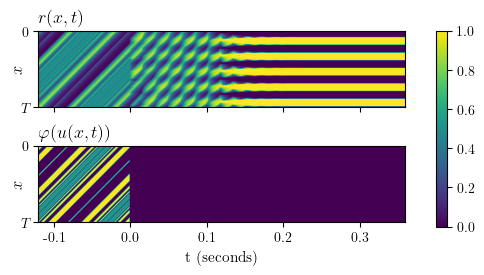

In [207]:
%matplotlib inline
fig, axes = plt.subplots(2, 1, figsize=(5.7, 2.8), sharex=True)
start = 400
end = 2800
data = X_dream[start:end].T
t_data = t_dream[start:end]
U = phi(u3(t_data[start:2*N, np.newaxis] + theta, T))
im_data = axes[0].imshow(data, vmax=1, vmin=0,
                         extent=[t_data[0], t_data[-1], N/len(data.T)*(t_data[-1]-t_data[0]), 0])
axes[0].set_yticks([0, T], [r'$0$', r'$T$'])
axes[0].set_ylabel('$x$', fontsize=12, labelpad=-3)
axes[1].imshow(np.vstack((U, np.zeros((end-2*N, N)))).T, vmax=1, vmin=0,
               extent=[t_data[0], t_data[-1], N/len(data.T)*(t_data[-1]-t_data[0]), 0])
axes[1].set_xticks(np.arange(0.1, 0.6, 0.1), np.arange(-0.1, 0.31, 0.1).round(1))
axes[1].set_xlabel(r"t (seconds)", fontsize=11)
axes[1].set_yticks([0, T], [r'$0$', r'$T$'])
axes[1].set_ylabel('$x$', fontsize=12, labelpad=-3)
axes[0].set_title(r"$r(x, t)$", size=13, loc='left')
axes[1].set_title(r"$\varphi(u(x, t))$", size=13, loc='left')
#sm0 = plt.cm.ScalarMappable(cmap=plt.cm.viridis, norm=plt.Normalize(vmin=0, vmax=1))
#plt.colorbar(sm0, ax=axes[0], aspect=12, location='left', ticks=[0, 1]).set_label(label=r"$r(x, t)$", size=12)
#sm1 = plt.cm.ScalarMappable(cmap=plt.cm.viridis, norm=plt.Normalize(vmin=0, vmax=1))
#plt.colorbar(sm1, ax=axes[1], aspect=12, location='left', ticks=[0, 1]).set_label(label=r"$\varphi(u(x, t))$", size=12)
cax = fig.add_axes([0.9, 0.18, 0.02, 0.7])
plt.colorbar(im_data, cax=cax)
plt.tight_layout()
plt.savefig('../latex/images/complex_stable_replay.pdf', bbox_inches='tight')

## Special Case $\tau_d/T = 0.75$

In [134]:
tau_d_stable = T * 0.75
delay_i_stable = round(tau_d_stable / dt)

In [135]:
alpha, tau_d_stable / T, simulation_duration_dream/T, beta

(200.0, 0.7500000000000001, 10.0, 0.02)

In [234]:
x_stable = get_x_from_u(u(t[-1] + theta, T))
w_stable = get_w_from_x(x_stable, delay_i_stable)

In [235]:
%%time
(
    X_, _
) = simulate(dt, N, T, t_dream, theta, alpha, 0, delay_i_stable, lmbda, w_stable.copy(),
             get_dw_prime_mean, get_dx, f_I_conv_circ_fft, phi, u,
             stimulate=False, full_info=False, init_stimulation=True, init_travel=0, init_steps=2*N)

CPU times: user 1.79 s, sys: 4.15 ms, total: 1.79 s
Wall time: 1.79 s


/tmp/ipykernel_11569/422504013.py:27: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


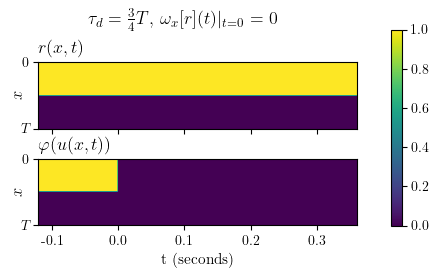

In [236]:
%matplotlib inline
fig, axes = plt.subplots(2, 1, figsize=(5.2, 2.8), sharex=True)
start = 400
end = 2800
data = X_[start:end].T
t_data = t_dream[start:end]
U = phi(u(np.zeros(2*N)[start:2*N, np.newaxis] + theta, T))
im_data = axes[0].imshow(data, vmax=1, vmin=0,
                         extent=[t_data[0], t_data[-1], N/len(data.T)*(t_data[-1]-t_data[0]), 0])
axes[0].set_yticks([0, T], [r'$0$', r'$T$'])
axes[0].set_ylabel('$x$', fontsize=12, labelpad=-3)
axes[1].imshow(np.vstack((U, np.zeros((end-2*N, N)))).T, vmax=1, vmin=0,
               extent=[t_data[0], t_data[-1], N/len(data.T)*(t_data[-1]-t_data[0]), 0])
axes[1].set_xticks(np.arange(0.1, 0.6, 0.1), np.arange(-0.1, 0.31, 0.1).round(1))
axes[1].set_xlabel(r"t (seconds)", fontsize=11)
axes[1].set_yticks([0, T], [r'$0$', r'$T$'])
axes[1].set_ylabel('$x$', fontsize=12, labelpad=-3)
axes[0].set_title(r"$r(x, t)$", size=13, loc='left')
axes[1].set_title(r"$\varphi(u(x, t))$", size=13, loc='left')
#sm0 = plt.cm.ScalarMappable(cmap=plt.cm.viridis, norm=plt.Normalize(vmin=0, vmax=1))
#plt.colorbar(sm0, ax=axes[0], aspect=12, location='left', ticks=[0, 1]).set_label(label=r"$r(x, t)$", size=12)
#sm1 = plt.cm.ScalarMappable(cmap=plt.cm.viridis, norm=plt.Normalize(vmin=0, vmax=1))
#plt.colorbar(sm1, ax=axes[1], aspect=12, location='left', ticks=[0, 1]).set_label(label=r"$\varphi(u(x, t))$", size=12)
cax = fig.add_axes([0.9, 0.18, 0.02, 0.7])
plt.colorbar(im_data, cax=cax)
fig.suptitle(r"$\tau_d = \frac{3}{4}T$, $\omega_x[r](t)|_{t=0}$ = 0", y=0.95, fontsize=13)
plt.tight_layout()
plt.savefig('../latex/images/simple_standing_wave.pdf', bbox_inches='tight')

# other

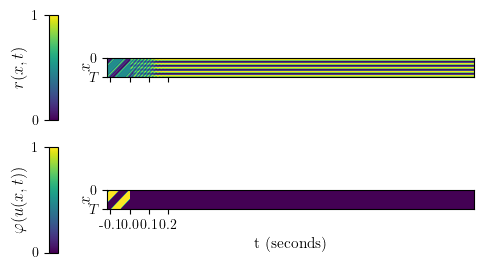

In [181]:
%matplotlib inline
fig, axes = plt.subplots(2, 1, figsize=(5.2, 2.8), sharex=True)
start = 400
end = 10000
data = X_dream[start:end].T
t_data = t_dream[start:end]
U = phi(u(t_dream[start:2*N, np.newaxis] + theta, T))
axes[0].imshow(data, vmax=data.max(), vmin=data.min(),
               extent=[t_data[0], t_data[-1], N/len(data.T)*(t_data[-1]-t_data[0]), 0])
axes[0].set_yticks([0, T], [r'$0$', r'$T$'])
axes[0].set_ylabel('$x$', fontsize=12, labelpad=-3)
axes[1].imshow(np.vstack((U, np.zeros((end-2*N, N)))).T,
               extent=[t_data[0], t_data[-1], N/len(data.T)*(t_data[-1]-t_data[0]), 0])
axes[1].set_xticks(np.arange(0.1, 0.5, 0.1), np.arange(-0.1, 0.21, 0.1).round(1))
axes[1].set_xlabel(r"t (seconds)", fontsize=11)
axes[1].set_yticks([0, T], [r'$0$', r'$T$'])
axes[1].set_ylabel('$x$', fontsize=12, labelpad=-3)
sm0 = plt.cm.ScalarMappable(cmap=plt.cm.viridis, norm=plt.Normalize(vmin=0, vmax=1))
plt.colorbar(sm0, ax=axes[0], aspect=12, location='left', ticks=[0, 1]).set_label(label=r"$r(x, t)$", size=12)
sm1 = plt.cm.ScalarMappable(cmap=plt.cm.viridis, norm=plt.Normalize(vmin=0, vmax=1))
plt.colorbar(sm1, ax=axes[1], aspect=12, location='left', ticks=[0, 1]).set_label(label=r"$\varphi(u(x, t))$", size=12)
plt.tight_layout()
#plt.savefig('../latex/images/basic_replay.pdf', bbox_inches='tight')